### Importación de librerías

In [1]:
import librosa
import librosa.display
import tqdm
import os
import scipy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

import dtale as dt
import seaborn as sns
import warnings 
warnings.filterwarnings('ignore')

----

### Lectura de los datasets

In [2]:
urbansound8k_path = "../../data/raw/UrbanSound8K/"

# Primer dataset - Carpeta con los audios
urbansound8k_audio_path = "audio/"

# Segundo dataset - Archivo CSV con metadatos de los audios
urbansound8k_metadata_path_file = "metadata/UrbanSound8K.csv"

In [17]:
def listar_archivos(directorio, nivel=0, max_nivel=None):
    contenidos = os.listdir(directorio)
    for contenido in contenidos[:3]:
        ruta_contenido = os.path.join(directorio, contenido)
        print(' ' * (nivel * 4) + '|-- ' + contenido)
        if os.path.isdir(ruta_contenido):
            listar_archivos(ruta_contenido, nivel + 1, max_nivel)

# Llamada a la función
listar_archivos(urbansound8k_path + urbansound8k_audio_path)

|-- .DS_Store
|-- fold1
    |-- .DS_Store
    |-- 101415-3-0-2.wav
    |-- 101415-3-0-3.wav
|-- fold10
    |-- .DS_Store
    |-- 100648-1-0-0.wav
    |-- 100648-1-1-0.wav


In [5]:
metadata_urbansound8k_df = pd.read_csv( urbansound8k_path + urbansound8k_metadata_path_file, sep=",")
display(metadata_urbansound8k_df.head(1))

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark


----

### Descripción de los datasets

In [6]:
def contar_archivos_por_extension(directorio, nivel=0, max_nivel=None):
    if max_nivel is not None and nivel > max_nivel:
        return defaultdict(int)
    
    # Diccionario para contar extensiones
    conteo_extensiones = defaultdict(int)
    contenidos = os.listdir(directorio)
    
    for contenido in contenidos:
        ruta_contenido = os.path.join(directorio, contenido)
        
        if os.path.isfile(ruta_contenido):
            _, extension = os.path.splitext(contenido)
            conteo_extensiones[extension] += 1
        
        elif os.path.isdir(ruta_contenido):
            subconteo = contar_archivos_por_extension(ruta_contenido, nivel + 1, max_nivel)
            for ext, count in subconteo.items():
                conteo_extensiones[ext] += count

    print(' ' * (nivel * 4) + f"{directorio}: {dict(conteo_extensiones)}")

    return conteo_extensiones 

print("Conteo de archivos por extension")
conteo_global = contar_archivos_por_extension(urbansound8k_path + urbansound8k_audio_path)

Conteo de archivos por extension
    ../../data/raw/UrbanSound8K/audio/fold1: {'': 1, '.wav': 873}


    ../../data/raw/UrbanSound8K/audio/fold10: {'': 1, '.wav': 837}
    ../../data/raw/UrbanSound8K/audio/fold2: {'': 1, '.wav': 888}
    ../../data/raw/UrbanSound8K/audio/fold3: {'': 1, '.wav': 925}
    ../../data/raw/UrbanSound8K/audio/fold4: {'': 1, '.wav': 990}
    ../../data/raw/UrbanSound8K/audio/fold5: {'': 1, '.wav': 936}
    ../../data/raw/UrbanSound8K/audio/fold6: {'': 1, '.wav': 823}
    ../../data/raw/UrbanSound8K/audio/fold7: {'': 1, '.wav': 838}
    ../../data/raw/UrbanSound8K/audio/fold8: {'': 1, '.wav': 806}
    ../../data/raw/UrbanSound8K/audio/fold9: {'': 1, '.wav': 816}
../../data/raw/UrbanSound8K/audio/: {'': 11, '.wav': 8732}


In [7]:
def reporte_descripcion_dataset(df):
    columnas = df.columns
    print("Columnas del dataset:\n")
    for col in columnas:
        print(col)
    print(f"\nCantidad de filas: {df.shape[0]}")

In [8]:
print("Descripción del dataset 'metadata_urbansound8k_df'")
reporte_descripcion_dataset(metadata_urbansound8k_df)

Descripción del dataset 'metadata_urbansound8k_df'
Columnas del dataset:

slice_file_name
fsID
start
end
salience
fold
classID
class

Cantidad de filas: 8732


In [9]:
metadata_urbansound8k_df.describe()

,fsID,start,end,salience,fold,classID
count,8732.000000,8732.000000,8732.000000,8732.000000,8732.000000,8732.000000
mean,116033.493816,38.645409,42.253312,1.347000,5.385937,4.592877
std,57991.017218,74.292126,74.369669,0.476043,2.846820,2.894544
min,344.000000,0.000000,0.105962,1.000000,1.000000,0.000000
25%,69942.250000,3.000000,6.839398,1.000000,3.000000,2.000000
50%,118279.000000,10.376492,14.000000,1.000000,5.000000,4.000000
75%,166942.000000,35.131372,38.866979,2.000000,8.000000,7.000000
max,209992.000000,600.125356,604.125356,2.000000,10.000000,9.000000


In [12]:
# Distribución de las clases a través de los diferentes folders
cruce_folder_clase_df = metadata_urbansound8k_df
cruce_folder_clase_df['fold_str'] = 'fold' + cruce_folder_clase_df['fold'].astype(str)

tabla_cruzada = pd.crosstab(index=cruce_folder_clase_df['class'],
                            columns=cruce_folder_clase_df['fold_str'],
                            margins=True)
tabla_cruzada.rename(columns={'All': 'Total'}, index={'All': 'Total'}, inplace=True)
display(tabla_cruzada)

fold_str,fold1,fold10,fold2,fold3,fold4,fold5,fold6,fold7,fold8,fold9,Total
class,,,,,,,,,,,
air_conditioner,100,100,100,100,100,100,100,100,100,100,1000
car_horn,36,33,42,43,59,98,28,28,30,32,429
children_playing,100,100,100,100,100,100,100,100,100,100,1000
dog_bark,100,100,100,100,100,100,100,100,100,100,1000
drilling,100,100,100,100,100,100,100,100,100,100,1000
engine_idling,96,93,100,107,107,107,107,106,88,89,1000
gun_shot,35,32,35,36,38,40,46,51,30,31,374
jackhammer,120,96,120,120,120,120,68,76,78,82,1000
siren,86,83,91,119,166,71,74,77,80,82,929


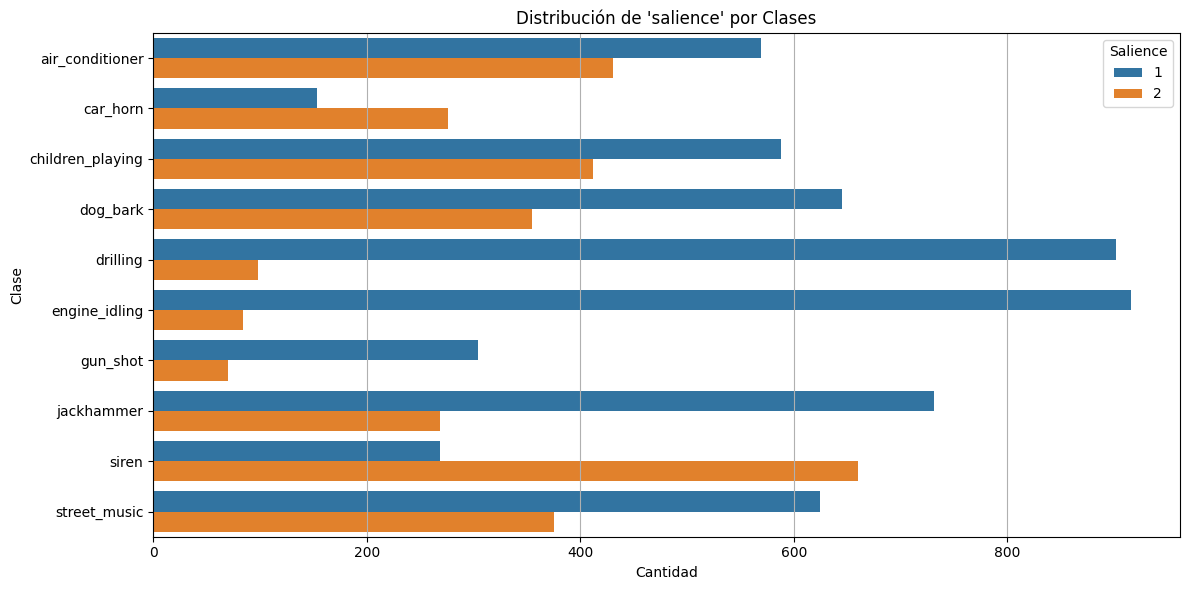

In [14]:
# Crear una lista ordenada de clases según 'classID'
class_order = (metadata_urbansound8k_df[['classID', 'class']]
               .drop_duplicates()
               .sort_values('classID'))

ordered_classes = class_order['class'].tolist()

# Generar el gráfico con las clases ordenadas por 'classID'
plt.figure(figsize=(12, 6))
ax = sns.countplot(y='class',
                   data=metadata_urbansound8k_df,
                   order=ordered_classes,
                   hue='salience',
                   palette=sns.color_palette(n_colors=10))

plt.title("Distribución de 'salience' por Clases")
plt.xlabel("Cantidad")
plt.ylabel("Clase")
plt.legend(title='Salience', loc='upper right')
plt.grid(axis='x')
plt.tight_layout()
plt.show()

----

### Carga de audio (Librosa)

In [8]:
# https://librosa.org/doc/0.10.2/generated/librosa.load.html#librosa.load

indice_archivo_audio_analisis = 5
nombre_archivo_audio = metadata_urbansound8k_df['slice_file_name'][indice_archivo_audio_analisis]
folder_archivo_audio = metadata_urbansound8k_df['fold'][indice_archivo_audio_analisis]
ruta_archivo_audio = f"{urbansound8k_path}/audio/fold{folder_archivo_audio}/{nombre_archivo_audio}"

serie_tiempo, tasa_muestreo_hz = librosa.load(ruta_archivo_audio, sr=None, mono=False)
print(f"Tasa de muestreo (hz) : {tasa_muestreo_hz}") 
print(f"Serie temporal de audio : {serie_tiempo}")
print(f"Número total de muestras : {serie_tiempo.shape}") 

Tasa de muestreo (hz) : 44100
Serie temporal de audio : [[0.00668335 0.00656128 0.00622559 ... 0.01028442 0.00976562 0.00949097]
 [0.00436401 0.00671387 0.00878906 ... 0.00125122 0.00216675 0.00280762]]
Número total de muestras : (2, 176400)


----

### Obtención de nuevos metadatos

In [9]:
audio_duracion_list = []
audio_tasa_muestreo_list = []
audio_cantidad_canales_list = []
audio_rango_dinamico_list = []
audio_tasa_cruce_cero_list = []
audio_entropia_espectograma_list = [] 
audio_path_list = []

muestras_duracion_sumatoria = 0
for index, row in metadata_urbansound8k_df.iterrows():
    path_total_file = f"{urbansound8k_path}/audio/fold{row['fold']}/{row['slice_file_name']}"
    serie_tiempo, tasa_muestreo_hz = librosa.load(path_total_file, sr=None, mono=False)

    # Calcular la duración (en segundos) de una serie temporal de audio
    duracion_segundos = librosa.get_duration(y=serie_tiempo, sr=tasa_muestreo_hz)

    # Cantidad de canales
    cantidad_canales = len(serie_tiempo.shape)

    # Rango Dinámico: Variabilidad en la intensidad del sonido
    rango_dinamico = np.max(serie_tiempo) - np.min(serie_tiempo)   

    # Tasa de Cruces por Cero: mide cuántas veces la señal cruza la línea de cero en un período de tiempo
    zero_crossings = librosa.zero_crossings(serie_tiempo, pad=False)    
    tasa_cruce_cero = np.sum(zero_crossings)

    # Entropía del espectrograma: complejidad de los sonidos
    spec = np.abs(librosa.stft(serie_tiempo))**2
    entropia_espectograma = scipy.stats.entropy(spec.flatten())
    
    # Promedio del Centroide Espectral: Medida de la "frecuencia central" de una señal
    spectral_centroids = librosa.feature.spectral_centroid(y=serie_tiempo, sr=tasa_muestreo_hz)[0]    
    avg_centroide_espectral = np.mean(spectral_centroids)   

    audio_path_list.append(path_total_file)
    audio_duracion_list.append(duracion_segundos)
    audio_tasa_muestreo_list.append(tasa_muestreo_hz)
    audio_cantidad_canales_list.append(cantidad_canales)
    audio_rango_dinamico_list.append(rango_dinamico)
    audio_tasa_cruce_cero_list.append(tasa_cruce_cero)
    audio_entropia_espectograma_list.append(entropia_espectograma)

metadata_urbansound8k_df['path'] = audio_path_list
metadata_urbansound8k_df['duracion'] = audio_duracion_list
metadata_urbansound8k_df['tasa_muestreo'] = audio_tasa_muestreo_list
metadata_urbansound8k_df['cantidad_canales'] = audio_cantidad_canales_list
metadata_urbansound8k_df['rango_dinamico'] = audio_rango_dinamico_list
metadata_urbansound8k_df['tasa_cruce_cero'] = audio_tasa_cruce_cero_list
metadata_urbansound8k_df['entropia_espectograma'] = audio_entropia_espectograma_list


###  Guardamos nuevos metadatos

In [10]:
metadata_urbansound8k_df.to_csv("../../data/processed/cd02_nuevos_metadatos_v1.csv", sep=';', index=False)

In [3]:
dataset_urbansound8k_df = pd.read_csv("../../data/processed/cd02_nuevos_metadatos_v1.csv", sep=";")

In [19]:
(dataset_urbansound8k_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8732 entries, 0 to 8731
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   slice_file_name        8732 non-null   object 
 1   fsID                   8732 non-null   int64  
 2   start                  8732 non-null   float64
 3   end                    8732 non-null   float64
 4   salience               8732 non-null   int64  
 5   fold                   8732 non-null   int64  
 6   classID                8732 non-null   int64  
 7   class                  8732 non-null   object 
 8   path                   8732 non-null   object 
 9   duracion               8732 non-null   float64
 10  tasa_muestreo          8732 non-null   int64  
 11  cantidad_canales       8732 non-null   int64  
 12  rango_dinamico         8732 non-null   float64
 13  tasa_cruce_cero        8732 non-null   int64  
 14  entropia_espectograma  8732 non-null   float64
dtypes: f

In [20]:
dataset_urbansound8k_df.describe()

,fsID,start,end,salience,fold,classID,duracion,tasa_muestreo,cantidad_canales,rango_dinamico,tasa_cruce_cero,entropia_espectograma
count,8732.000000,8732.000000,8732.000000,8732.000000,8732.000000,8732.000000,8732.000000,8732.000000,8732.000000,8732.000000,8732.000000,8732.000000
mean,116033.493816,38.645409,42.253312,1.347000,5.385937,4.592877,3.607522,48456.979272,1.915369,0.915306,23527.114063,9.035663
std,57991.017218,74.292126,74.369669,0.476043,2.846820,2.894544,0.974394,15300.080707,0.278348,0.603300,23197.099947,1.431490
min,344.000000,0.000000,0.105962,1.000000,1.000000,0.000000,0.050000,8000.000000,1.000000,0.002143,86.000000,4.001312
25%,69942.250000,3.000000,6.839398,1.000000,3.000000,2.000000,4.000000,44100.000000,2.000000,0.383812,9188.000000,8.143867
50%,118279.000000,10.376492,14.000000,1.000000,5.000000,4.000000,4.000000,44100.000000,2.000000,0.822784,17201.000000,9.131977
75%,166942.000000,35.131372,38.866979,2.000000,8.000000,7.000000,4.000000,48000.000000,2.000000,1.379379,27514.000000,10.048465
max,209992.000000,600.125356,604.125356,2.000000,10.000000,9.000000,4.036647,192000.000000,2.000000,2.000000,284887.000000,12.527843


----

### Exploración con dtale

In [13]:
# Se usa la librería dtale para poder obtener una vista interactiva de los datos

# Dataset: metadatos de los audio + csv de metadatos
#dataset_urbansound8k_dtale = dt.show(dataset_urbansound8k_df)
#dataset_urbansound8k_dtale.open_browser()

### Exploracion por variable Clase

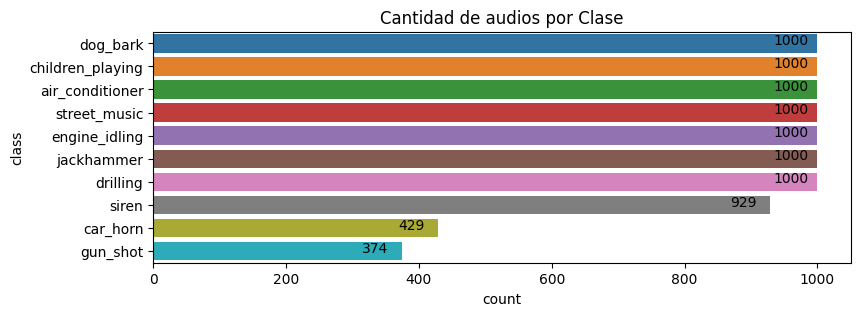

In [14]:
# Cantidad de audios por Clase
plt.figure(figsize=(9,3))
ax = sns.countplot(y=dataset_urbansound8k_df['class'], 
              order=dataset_urbansound8k_df['class'].value_counts().index,
              palette =sns.color_palette(n_colors=10))

for p in ax.patches:
    width = p.get_width()  # Anchura de la barra
    plt.text(width - 40,  # Posición en el eje x (ligeramente desplazado a la derecha)
             p.get_y() + p.get_height() / 3,  # Posición en el eje y
             int(width),  # El valor de la cantidad
             ha='center', va='center')  # Alineación del texto

plt.title("Cantidad de audios por Clase")
plt.show()

2024-09-22 12:56:31,931 - INFO     - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-09-22 12:56:31,948 - INFO     - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


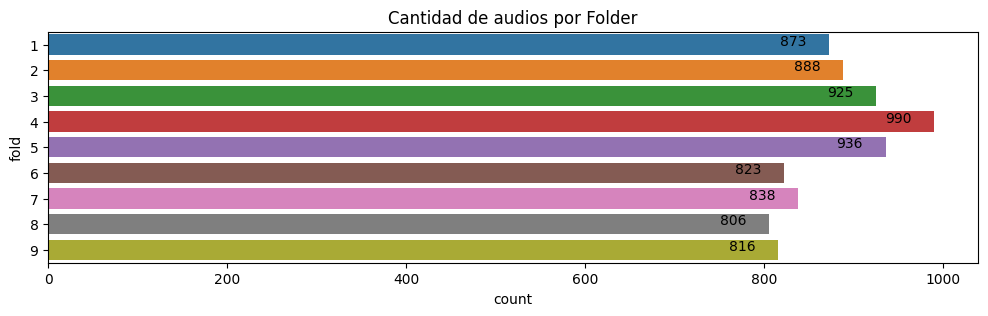

In [15]:
# Cantidad de audios por Folder
plt.figure(figsize=(12,3))
ax = sns.countplot(y=dataset_urbansound8k_df['fold'], 
              order=[num for num in range(1,10)],
              palette =sns.color_palette(n_colors=10))

for p in ax.patches:
    width = p.get_width()  # Anchura de la barra
    plt.text(width - 40,  # Posición en el eje x (ligeramente desplazado a la derecha)
             p.get_y() + p.get_height() / 3,  # Posición en el eje y
             int(width),  # El valor de la cantidad
             ha='center', va='center')  # Alineación del texto

plt.title("Cantidad de audios por Folder")
plt.show()

In [16]:
dataset_urbansound8k_df['class'].value_counts().index

Index(['dog_bark', 'children_playing', 'air_conditioner', 'street_music',
       'engine_idling', 'jackhammer', 'drilling', 'siren', 'car_horn',
       'gun_shot'],
      dtype='object', name='class')

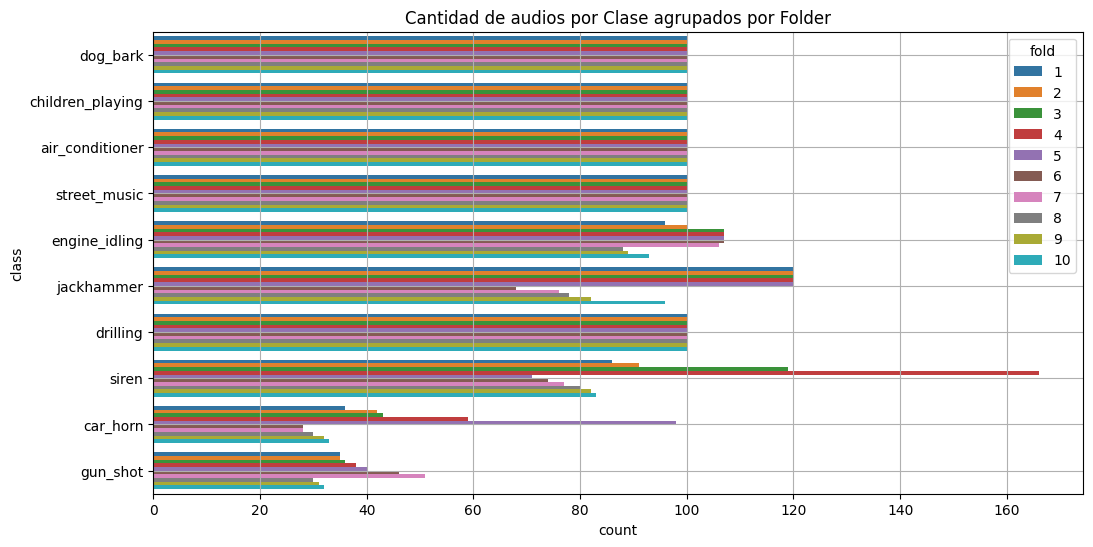

In [23]:


# Cantidad de audios por Clase agrupados por Folder
plt.figure(figsize=(12,6))
ax = sns.countplot(y=dataset_urbansound8k_df['class'], 
              order=dataset_urbansound8k_df['class'].value_counts().index, 
              hue=dataset_urbansound8k_df['fold'],
              palette =sns.color_palette(n_colors=10)) 

plt.title("Cantidad de audios por Clase agrupados por Folder")
plt.grid()
plt.show()


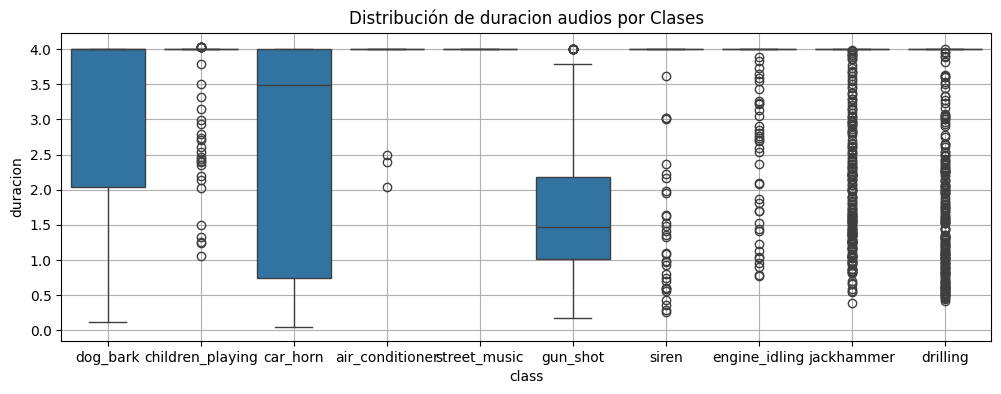

In [51]:
# Distribución de duracion audios por Clases
plt.figure(figsize=(12,4))
ax = sns.boxplot(y=dataset_urbansound8k_df['duracion'], x=dataset_urbansound8k_df['class']) 
plt.title("Distribución de duracion audios por Clases")
plt.grid()
plt.show()

In [69]:
# Distribución de duracion audios
result = dataset_urbansound8k_df.groupby(['duracion']).size().reset_index(name='count')
result = result.sort_values(by=['count'], ascending=[False])

display(result)

,duracion,count
970,4.000000,7325
512,1.440000,10
473,1.330000,10
368,1.090000,9
972,4.036647,7
...,...,...
132,0.520000,1
459,1.295646,1
460,1.305351,1
461,1.307279,1


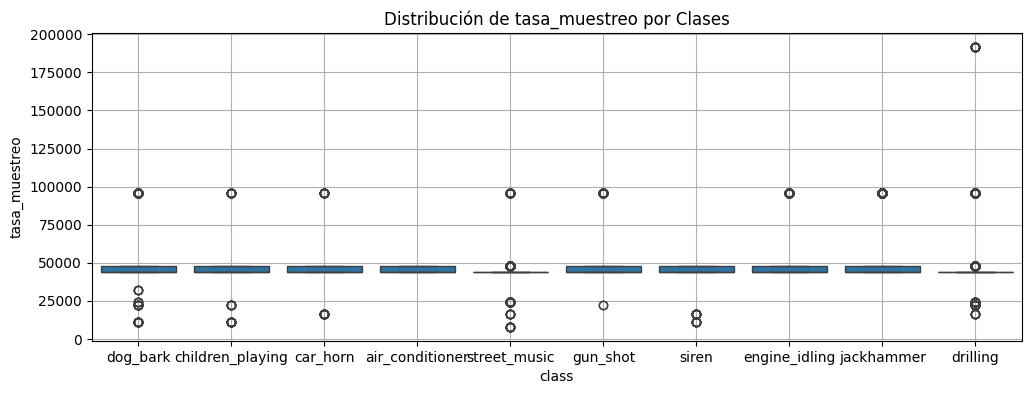

In [53]:
# Distribución de tasa_muestreo por Clases
plt.figure(figsize=(12,4))
ax = sns.boxplot(y=dataset_urbansound8k_df['tasa_muestreo'], x=dataset_urbansound8k_df['class']) 
plt.title("Distribución de tasa_muestreo por Clases")
plt.grid()
plt.show()

In [68]:
# Distribución de tasa_muestreo
result = dataset_urbansound8k_df.groupby(['tasa_muestreo']).size().reset_index(name='count')
result = result.sort_values(by=['count'], ascending=[False])

display(result)

,tasa_muestreo,count
7,44100,5370
8,48000,2502
9,96000,610
5,24000,82
3,16000,45
4,22050,44
2,11025,39
10,192000,17
0,8000,12
1,11024,7


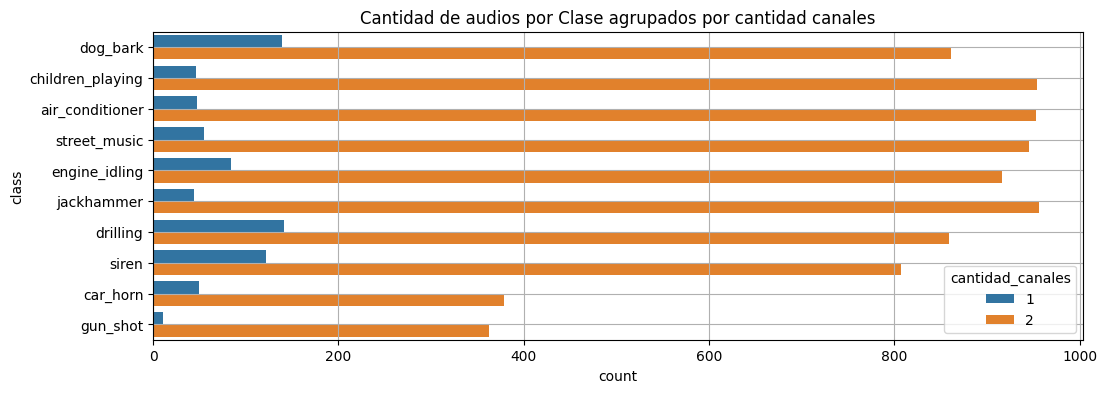

In [57]:
# Cantidad de audios por Clase agrupados por cantidad canales
plt.figure(figsize=(12,4))
ax = sns.countplot(y=dataset_urbansound8k_df['class'], 
              order=dataset_urbansound8k_df['class'].value_counts().index, 
              hue=dataset_urbansound8k_df['cantidad_canales'],
              palette =sns.color_palette(n_colors=10)) 

plt.title("Cantidad de audios por Clase agrupados por cantidad canales")
plt.grid()
plt.show()


In [70]:
# Distribución de tasa_muestreo
result = dataset_urbansound8k_df.groupby(['cantidad_canales']).size().reset_index(name='count')
result = result.sort_values(by=['count'], ascending=[False])

display(result)

,cantidad_canales,count
1,2,7993
0,1,739


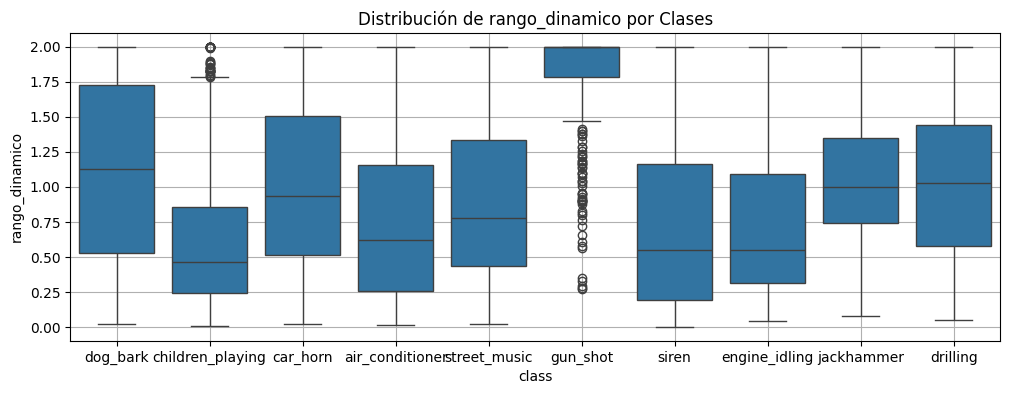

In [58]:
# Distribución de rango_dinamico por Clases
plt.figure(figsize=(12,4))
ax = sns.boxplot(y=dataset_urbansound8k_df['rango_dinamico'], x=dataset_urbansound8k_df['class']) 
plt.title("Distribución de rango_dinamico por Clases")
plt.grid()
plt.show()

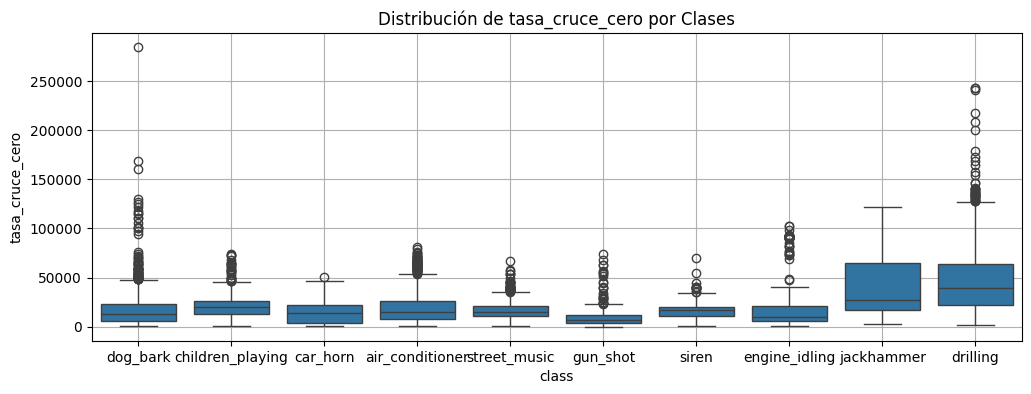

In [60]:
# Distribución de tasa_cruce_cero por Clases
plt.figure(figsize=(12,4))
ax = sns.boxplot(y=dataset_urbansound8k_df['tasa_cruce_cero'], x=dataset_urbansound8k_df['class']) 
plt.title("Distribución de tasa_cruce_cero por Clases")
plt.grid()
plt.show()

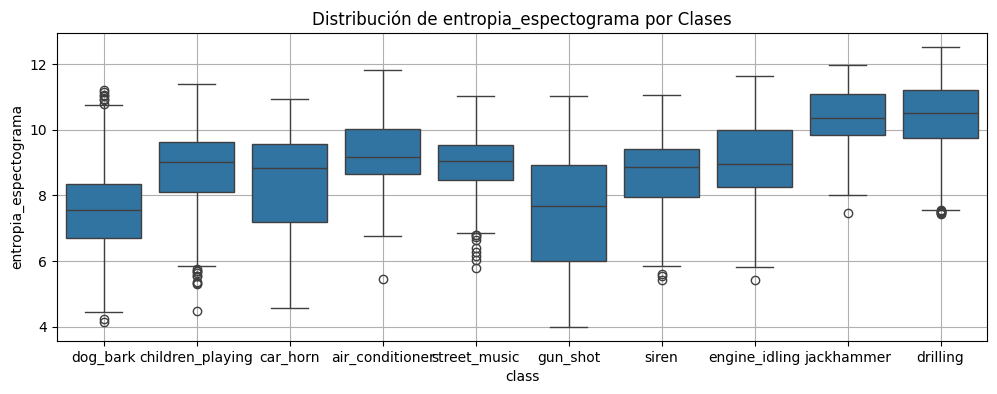

In [61]:
# Distribución de entropia_espectograma por Clases
plt.figure(figsize=(12,4))
ax = sns.boxplot(y=dataset_urbansound8k_df['entropia_espectograma'], x=dataset_urbansound8k_df['class']) 
plt.title("Distribución de entropia_espectograma por Clases")
plt.grid()
plt.show()

### Grafico de onda

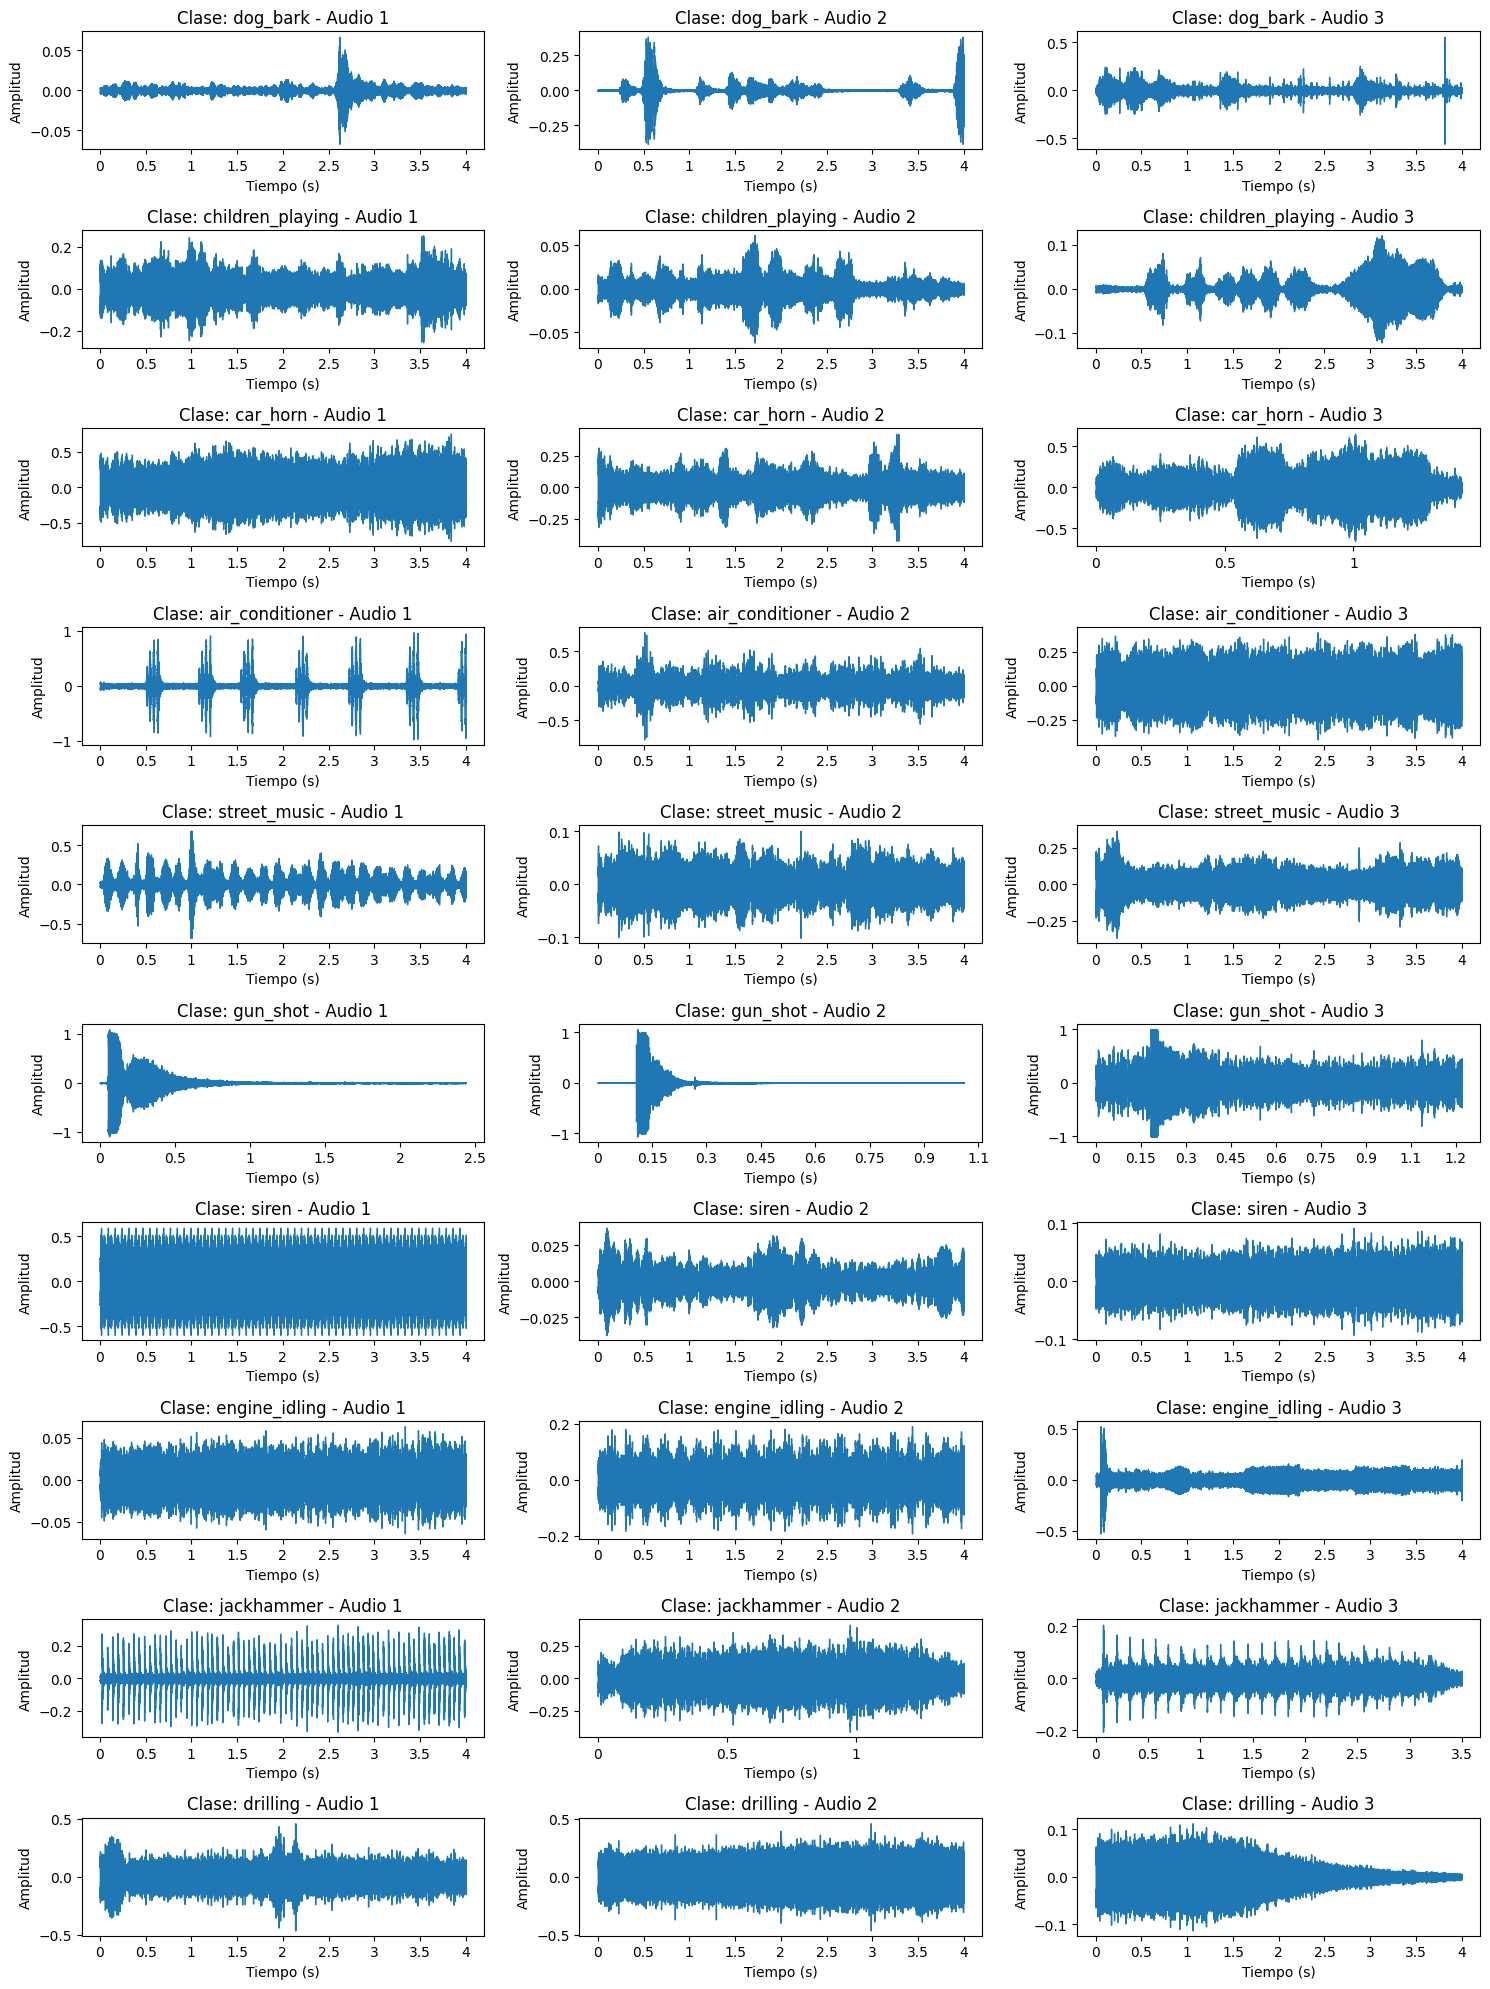

In [4]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import pandas as pd

# Suponiendo que ya tienes un DataFrame llamado `metadata_urbansound8k_df`
# con las columnas 'class' y 'file_path', donde 'file_path' es la ruta del archivo de audio

# Obtener las clases únicas
clases_unicas = dataset_urbansound8k_df['class'].unique()

# Establecer el número de muestras por clase
num_muestras_por_clase = 3

# Crear una figura y ejes para subplots
fig, axes = plt.subplots(nrows=len(clases_unicas), ncols=num_muestras_por_clase, figsize=(15, 20))
fig.tight_layout(pad=3.0)

# Recorrer cada clase
for i, clase in enumerate(clases_unicas):
    # Filtrar el DataFrame para obtener los archivos de la clase actual
    archivos_clase = dataset_urbansound8k_df[dataset_urbansound8k_df['class'] == clase]['path']
    
    # Seleccionar los primeros `num_muestras_por_clase` archivos
    archivos_seleccionados = archivos_clase.sample(n=num_muestras_por_clase, random_state=2)
    
    # Graficar las formas de onda
    for j, archivo in enumerate(archivos_seleccionados):
        signal, sr = librosa.load(archivo, sr=44100, mono=True)  # Cargar el archivo de audio
        
        # Graficar en la subfigura correspondiente
        ax = axes[i, j]
        librosa.display.waveshow(signal, sr=sr, ax=ax)
        ax.set_title(f'Clase: {clase} - Audio {j+1}')
        ax.set_xlabel('Tiempo (s)')
        ax.set_ylabel('Amplitud')

# Ajustar el layout para evitar superposición de títulos
plt.tight_layout()
plt.show()


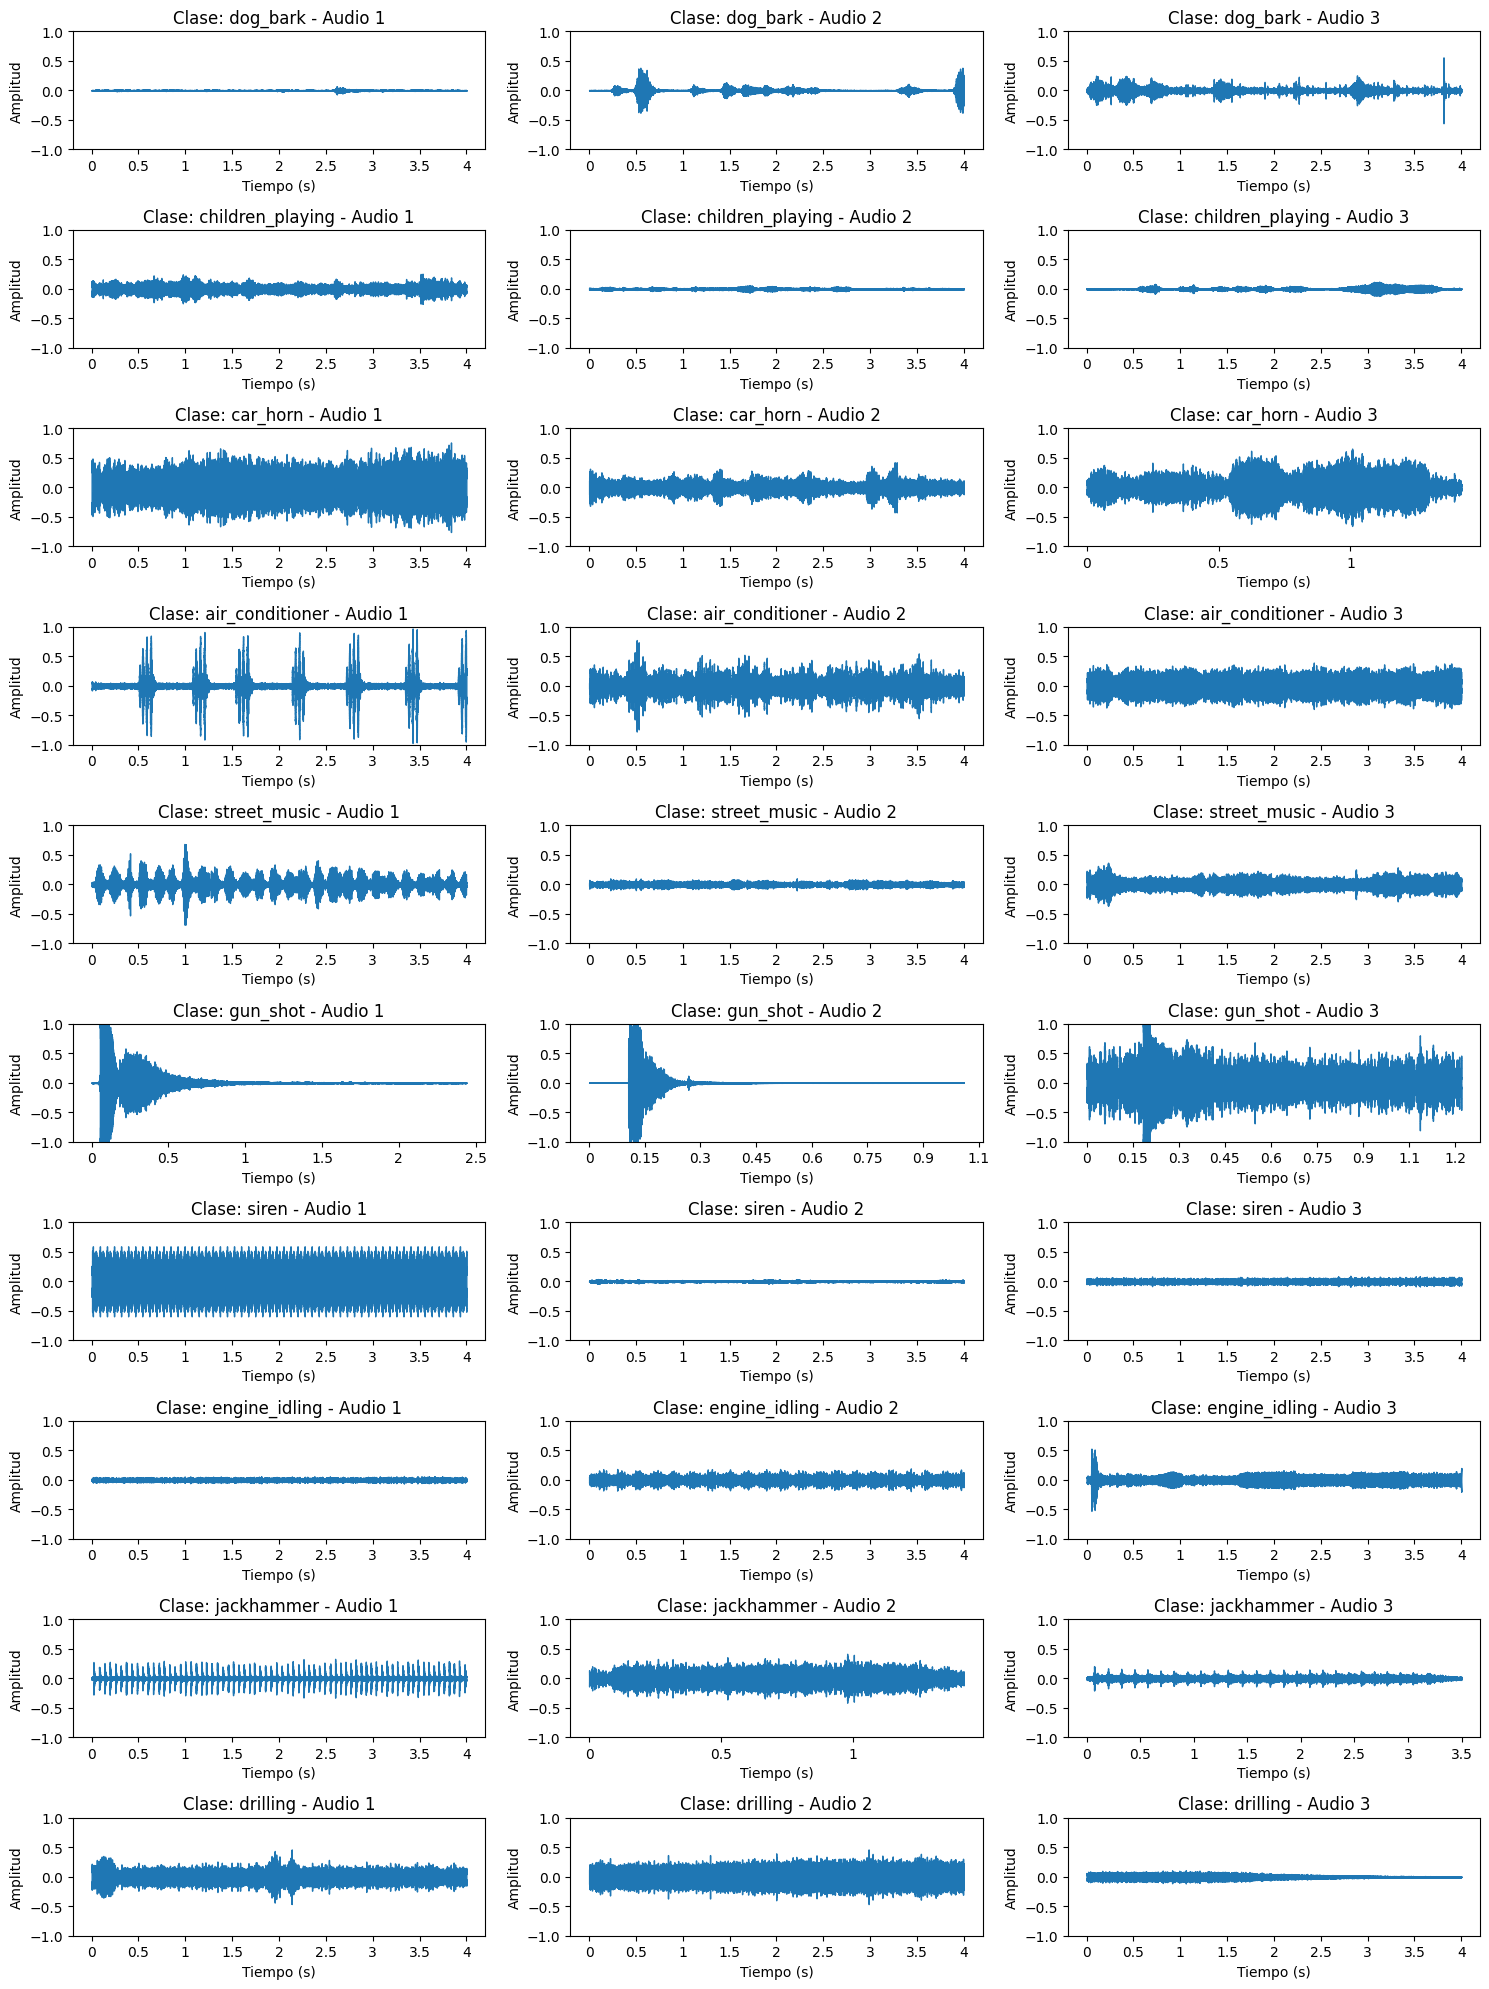

In [5]:
import librosa 
import librosa.display
import matplotlib.pyplot as plt
import pandas as pd

# Suponiendo que ya tienes un DataFrame llamado `dataset_urbansound8k_df`
# con las columnas 'class' y 'path', donde 'path' es la ruta del archivo de audio

# Obtener las clases únicas
clases_unicas = dataset_urbansound8k_df['class'].unique()

# Establecer el número de muestras por clase
num_muestras_por_clase = 3

# Crear una figura y ejes para subplots
fig, axes = plt.subplots(nrows=len(clases_unicas), ncols=num_muestras_por_clase, figsize=(15, 20))
fig.tight_layout(pad=3.0)

# Establecer los límites fijos para el eje vertical (amplitud)
# Como librosa escala la señal entre -1 y 1, este será un buen rango fijo.
amplitud_limite = (-1, 1)

# Recorrer cada clase
for i, clase in enumerate(clases_unicas):
    # Filtrar el DataFrame para obtener los archivos de la clase actual
    archivos_clase = dataset_urbansound8k_df[dataset_urbansound8k_df['class'] == clase]['path']
    
    # Seleccionar los primeros `num_muestras_por_clase` archivos
    archivos_seleccionados = archivos_clase.sample(n=num_muestras_por_clase, random_state=2)
    
    # Graficar las formas de onda
    for j, archivo in enumerate(archivos_seleccionados):
        signal, sr = librosa.load(archivo, sr=44100, mono=True)  # Cargar el archivo de audio
        
        # Graficar en la subfigura correspondiente
        ax = axes[i, j]
        librosa.display.waveshow(signal, sr=sr, ax=ax)
        ax.set_title(f'Clase: {clase} - Audio {j+1}')
        ax.set_xlabel('Tiempo (s)')
        ax.set_ylabel('Amplitud')
        
        # Establecer el límite fijo para la amplitud (eje Y)
        ax.set_ylim(amplitud_limite)

# Ajustar el layout para evitar superposición de títulos
plt.tight_layout()
plt.show()


### Correlacion Variables

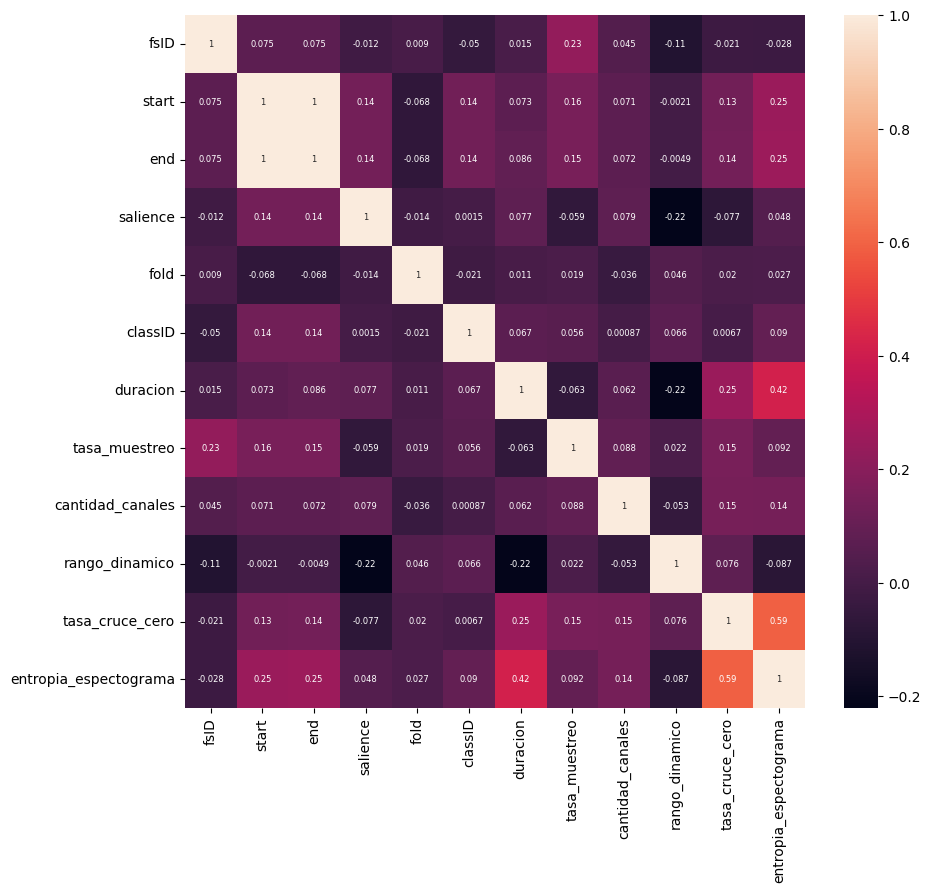

In [6]:
numeric_df = dataset_urbansound8k_df.select_dtypes(include=['float64', 'int64'])
correlacion_result = numeric_df.corr()
plt.figure(figsize=(10, 9))

sj_corr_heat = sns.heatmap(correlacion_result, annot=True, annot_kws={"size": 6})